In [8]:
import sys
import os

# Add particle_detection to sys.path
sys.path.append(os.path.abspath(".."))

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import cv2
#import torch.nn as nn
from particle_detection.autoencoder.model import create_autoencoder
from particle_detection.autoencoder.utils import load_model
from particle_detection.data.dataset import ImageDataset, get_transforms

In [10]:
model_path = "../saved_models/ae_1000_epochs.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_autoencoder().to(device)
model = load_model(model, model_path, device=device)
model.eval()

print("Model loaded successfully.")

[DEBUG] Loading model from: ../saved_models/ae_1000_epochs.pth
[DEBUG] Model loaded successfully from ../saved_models/ae_1000_epochs.pth.
Model loaded successfully.


In [11]:
#dataset_dir = "/home/blah-buttery/nanoparticles/images/normal"  # gpu workstation image location
dataset_dir = "/Users/blah_m4/Desktop/nanoparticle/images" # macbook image location
transform = get_transforms(image_size=(1024, 1024), is_train=False)

# Create the dataset and dataloader
dataset = ImageDataset(data_dir=dataset_dir, transform=transform, split="test", test_size=0.2)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False)

print(f"Loaded dataset with {len(dataset)} samples for evaluation.")


Loaded dataset with 3 samples for evaluation.


In [12]:
# get the latent space by passing dataset through encoder
with torch.no_grad():
    sample_img = next(iter(dataloader))
    sample_img = sample_img.to(device)
    latent_space = model.encoder(sample_img)
    print(f"Shape of latent space: {latent_space.shape}")

Shape of latent space: torch.Size([3, 512, 64, 64])


In [13]:
# reduce to 2d for clustering
latent_space_reshaped = latent_space.permute(0, 2, 3, 1).reshape(-1, latent_space.shape[1])  # Shape: [N, C]
print(f"Shape of reshaped latent space: {latent_space_reshaped.shape}")

Shape of reshaped latent space: torch.Size([12288, 512])


In [14]:
# apply initial gmm clustering

gmm = GaussianMixture(n_components=5, random_state=42, covariance_type="full")
gmm.fit(latent_space_reshaped.cpu().numpy())
cluster_labels = gmm.predict(latent_space_reshaped.cpu().numpy())

In [15]:
# Map Cluster Labels Back to Spatial Grid
grid_cols = latent_space.shape[3]  # 1024 / 8 = 128
grid_rows = latent_space.shape[2]  # 1024 / 8 = 128
cluster_labels_grid = cluster_labels.reshape(latent_space.shape[0], grid_rows, grid_cols)  # Shape: [B, H, W]

print(f"Cluster labels grid shape: {cluster_labels_grid.shape}")

Cluster labels grid shape: (3, 64, 64)


In [16]:
def visualize_clusters_on_image(image_batch, cluster_labels_grid):
    """
    Visualize clusters directly on the spatial grid of the image.
    
    Args:
        image_batch (torch.Tensor): Batch of images, shape [B, C, H, W].
        cluster_labels_grid (np.ndarray): Cluster labels, shape [B, H, W].
    
    Returns:
        None
    """
    # Select the first image and its cluster labels
    single_image = image_batch[0]  # Shape: [C, H, W]
    single_cluster_labels = cluster_labels_grid[0]  # Shape: [H, W]

    # Visualize the image and clusters
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    image_np = single_image.cpu().numpy().transpose(1, 2, 0)  # Convert CHW to HWC
    if image_np.max() > 1.0:
        image_np = image_np / 255.0  # Normalize
    plt.imshow(image_np, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    # Cluster Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(single_cluster_labels, cmap="viridis")
    plt.title("Cluster Visualization")
    plt.colorbar(label="Cluster")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

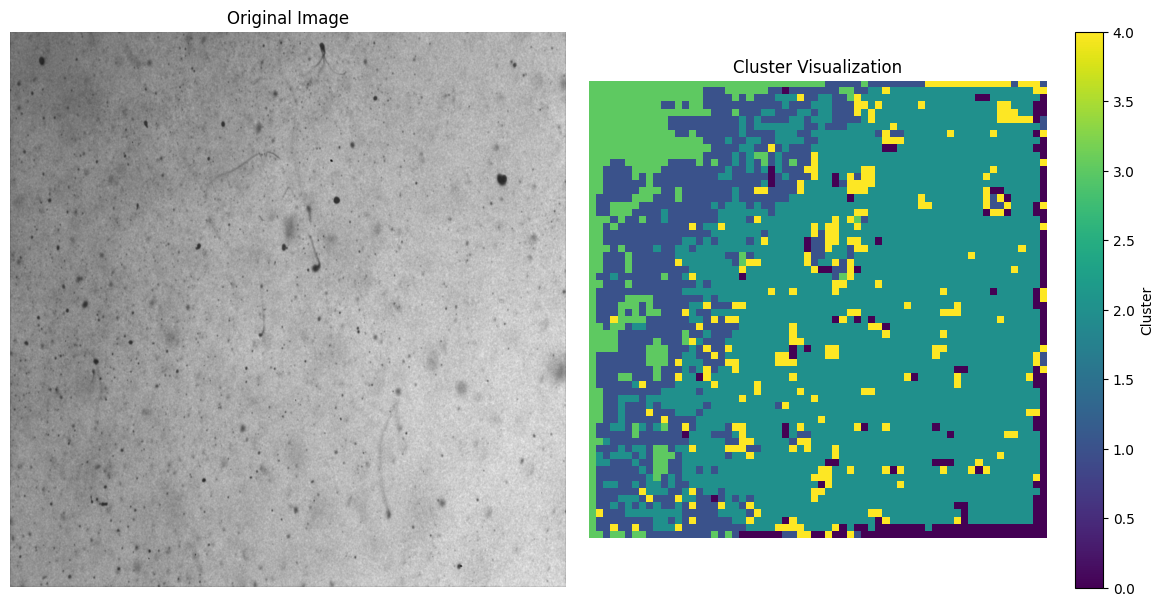

In [17]:
visualize_clusters_on_image(sample_img, cluster_labels_grid)

In [20]:
# okay, but can we improve the results?
# we can do this if we elimante some of the least important channels of the latent space
from sklearn.decomposition import PCA

# Convert PyTorch tensor to NumPy array
latent_space_np = latent_space_reshaped.cpu().numpy()  # Shape: [8192, 512]

# Apply PCA
n_components = 50  # Adjust based on your needs (e.g., explained variance)
pca = PCA(n_components=n_components)
latent_space_pca = pca.fit_transform(latent_space_np)  # Shape: [8192, 50]

print(f"Shape after PCA: {latent_space_pca.shape}")

Shape after PCA: (12288, 50)


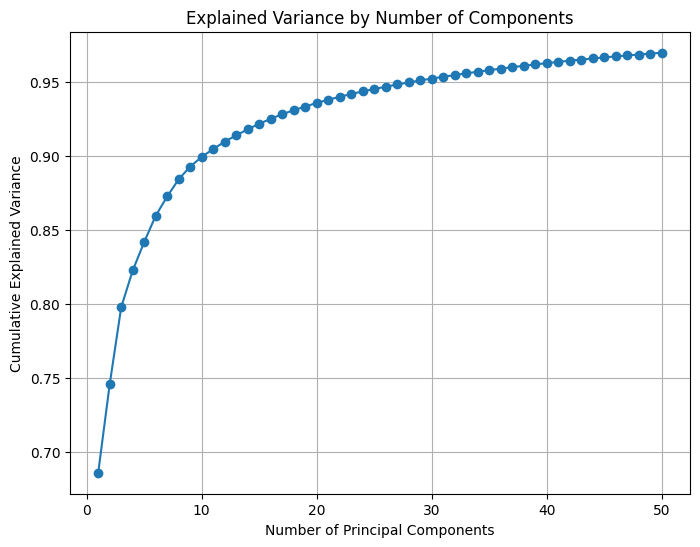

In [21]:
# Plot the explained variance
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Number of Components")
plt.grid()
plt.show()

In [22]:
pca = PCA(n_components=30)
latent_space_pca = pca.fit_transform(latent_space_np)  # Shape: [8192, 20]
print(f"Shape after PCA: {latent_space_pca.shape}")

Shape after PCA: (12288, 30)


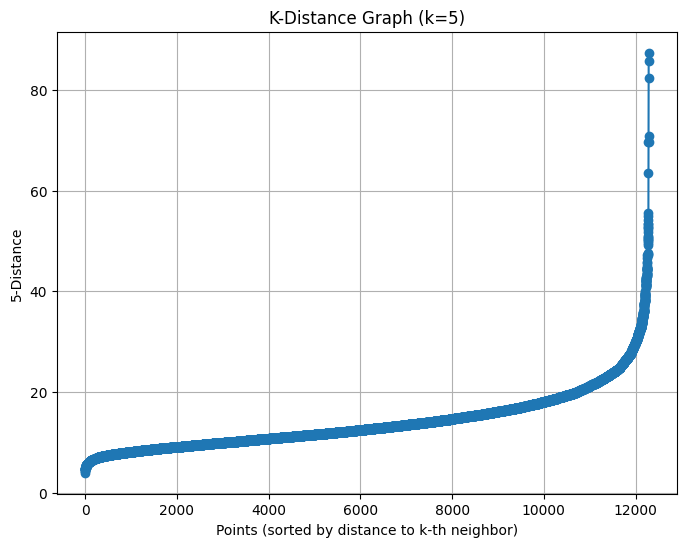

In [23]:
from sklearn.neighbors import NearestNeighbors

def plot_k_distance(data, k=5):
    """
    Plots the k-distance graph to help select the `eps` parameter for DBSCAN.
    
    Args:
        data (np.ndarray): Data for DBSCAN, shape [N, features].
        k (int): The k-th nearest neighbor to calculate distances for.
    
    Returns:
        None (plots the k-distance graph).
    """
    # Fit Nearest Neighbors model
    nbrs = NearestNeighbors(n_neighbors=k).fit(data)
    
    # Find distances to the k-th nearest neighbor for each point
    distances, _ = nbrs.kneighbors(data)
    
    # Extract the k-th nearest neighbor distances (column `k-1`)
    k_distances = np.sort(distances[:, k-1])  # Sort distances in ascending order
    
    # Plot the sorted k-distances
    plt.figure(figsize=(8, 6))
    plt.plot(k_distances, marker='o')
    plt.title(f"K-Distance Graph (k={k})")
    plt.xlabel("Points (sorted by distance to k-th neighbor)")
    plt.ylabel(f"{k}-Distance")
    plt.grid()
    plt.show()

# Example Usage:
latent_space_np = latent_space_reshaped.cpu().numpy()  # Ensure latent space is in NumPy format
plot_k_distance(latent_space_pca, k=5)  # Set k = min_samples - 1


In [25]:
gmm = GaussianMixture(n_components=20, random_state=42, covariance_type="full")
gmm.fit(latent_space_pca)  # Fit on reshaped latent space
cluster_labels = gmm.predict(latent_space_pca)  # Shape: [N]

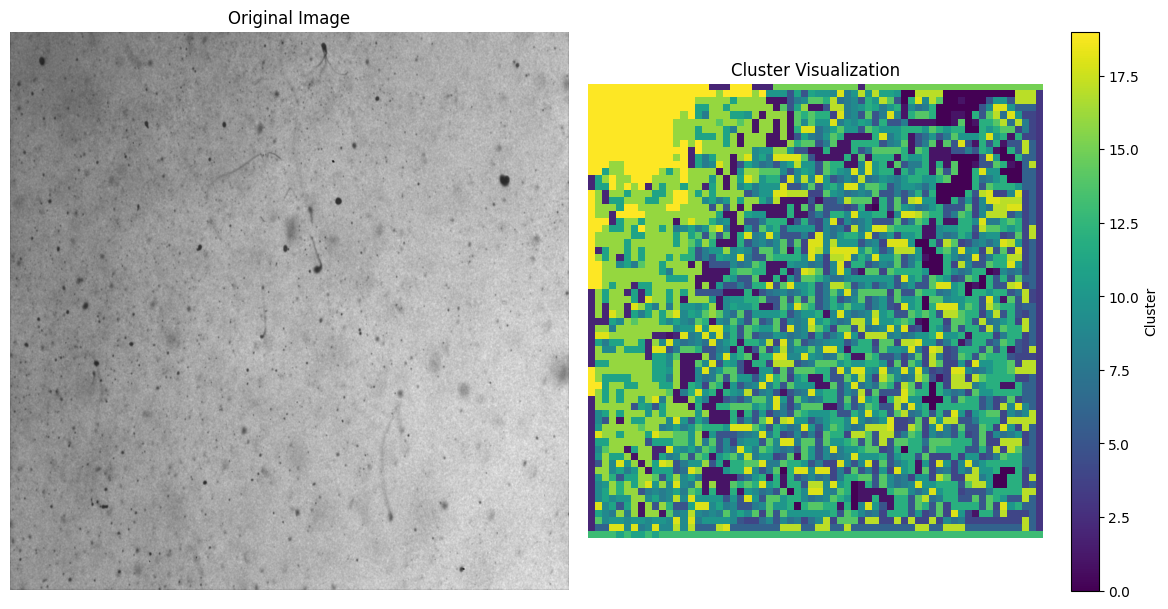

In [26]:
visualize_clusters_on_image(sample_img, cluster_labels_grid)

In [27]:
def gmm_grid_search(data, n_components_range, covariance_types):
    best_gmm = None
    best_bic = np.inf
    best_params = {}
    
    for n_components in n_components_range:
        for covariance_type in covariance_types:
            gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
            gmm.fit(data)
            
            # Compute BIC
            bic = gmm.bic(data)
            print(f"BIC for n_components={n_components}, covariance_type={covariance_type}: {bic}")
            
            # Update best model if BIC improves
            if bic < best_bic:
                best_bic = bic
                best_gmm = gmm
                best_params = {"n_components": n_components, "covariance_type": covariance_type}
    
    print(f"Best parameters: {best_params}, Best BIC: {best_bic}")
    return best_gmm, best_params

In [28]:
n_components_range = range(14, 40)
covariance_types = ["full", "tied", "diag", "spherical"]
best_gmm, best_params = gmm_grid_search(latent_space_pca, n_components_range, covariance_types)

BIC for n_components=14, covariance_type=full: 1711178.5204080902
BIC for n_components=14, covariance_type=tied: 1933713.3886307771
BIC for n_components=14, covariance_type=diag: 1880473.9270354065
BIC for n_components=14, covariance_type=spherical: 2087037.59955637
BIC for n_components=15, covariance_type=full: 1708323.648453187
BIC for n_components=15, covariance_type=tied: 1931061.5023219837
BIC for n_components=15, covariance_type=diag: 1878119.1297199605
BIC for n_components=15, covariance_type=spherical: 2074583.3303421289
BIC for n_components=16, covariance_type=full: 1707642.5125976976
BIC for n_components=16, covariance_type=tied: 1912909.6811829428
BIC for n_components=16, covariance_type=diag: 1874795.2331488775
BIC for n_components=16, covariance_type=spherical: 2067521.3961559478
BIC for n_components=17, covariance_type=full: 1709403.3417664762
BIC for n_components=17, covariance_type=tied: 1911768.4210988292
BIC for n_components=17, covariance_type=diag: 1871985.402604709

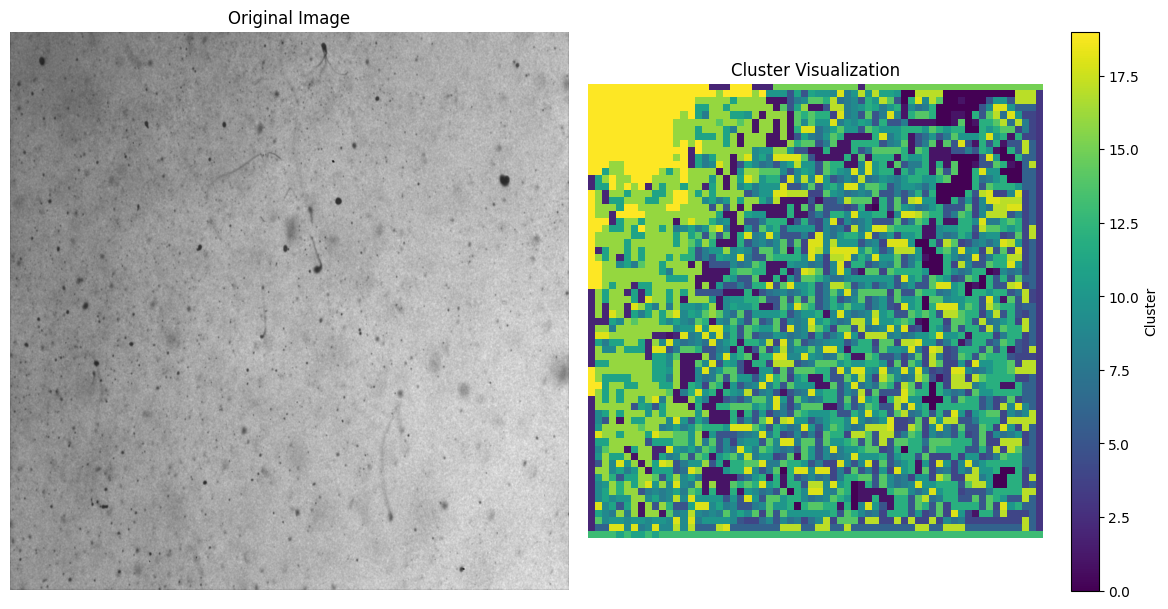

In [29]:
gmm = GaussianMixture(n_components=20, random_state=42, covariance_type="full")
gmm.fit(latent_space_pca)  # Fit on reshaped latent space
cluster_labels = gmm.predict(latent_space_pca)  # Shape: [N]

cluster_labels_grid = cluster_labels.reshape(latent_space.shape[0], grid_rows, grid_cols) 

visualize_clusters_on_image(sample_img, cluster_labels_grid)

Unique cluster labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


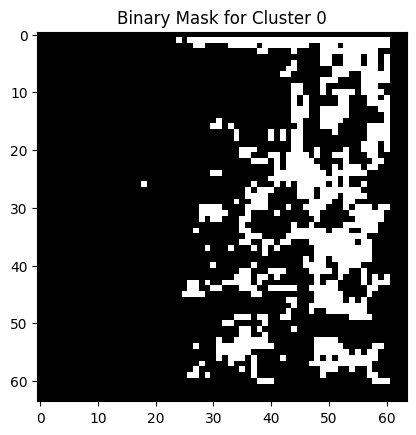

Cluster 0: Found 29 contours.


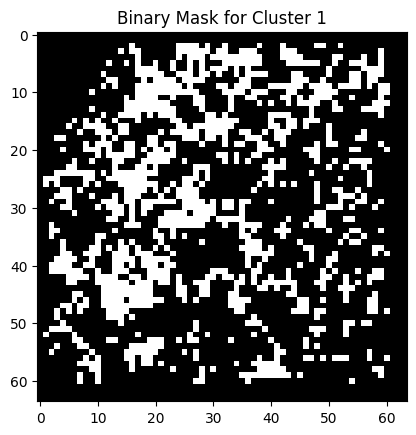

Cluster 1: Found 92 contours.


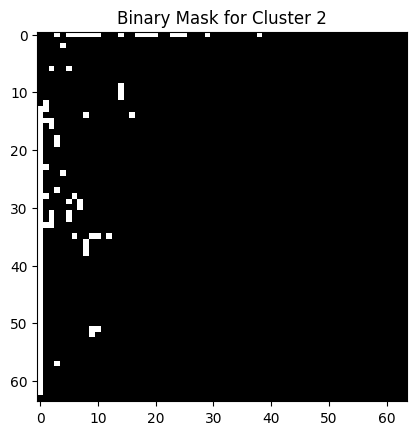

Cluster 2: Found 24 contours.


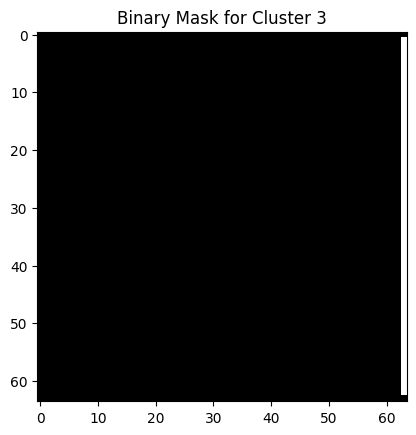

Cluster 3: Found 1 contours.


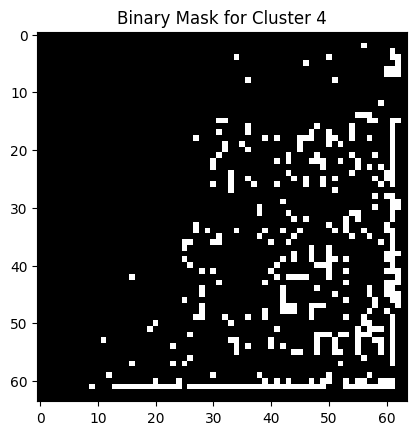

Cluster 4: Found 106 contours.


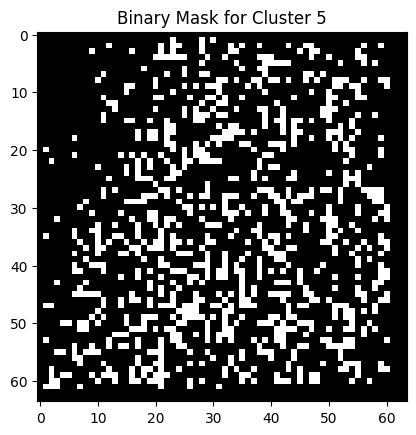

Cluster 5: Found 183 contours.


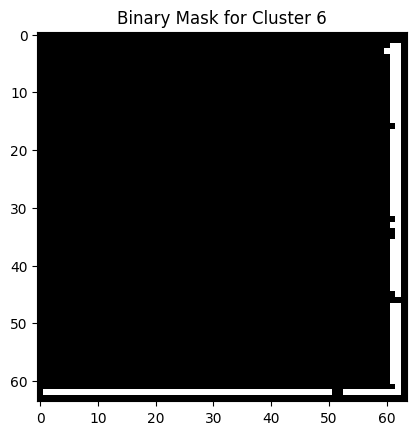

Cluster 6: Found 3 contours.


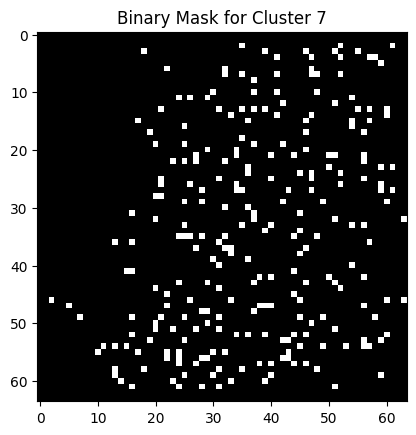

Cluster 7: Found 186 contours.


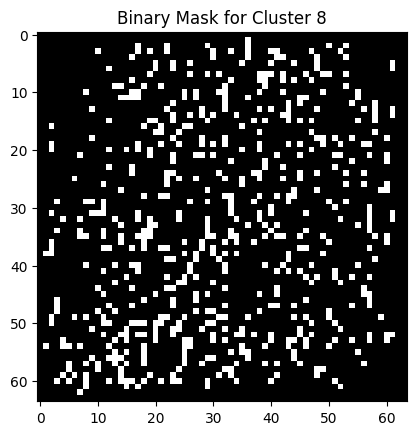

Cluster 8: Found 252 contours.


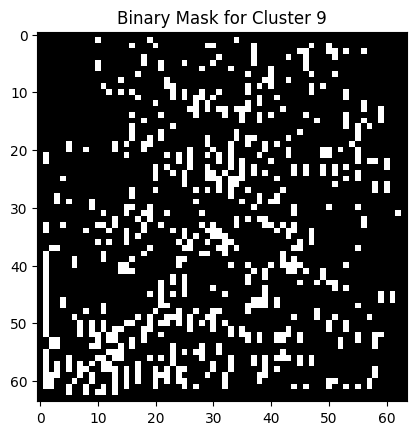

Cluster 9: Found 206 contours.


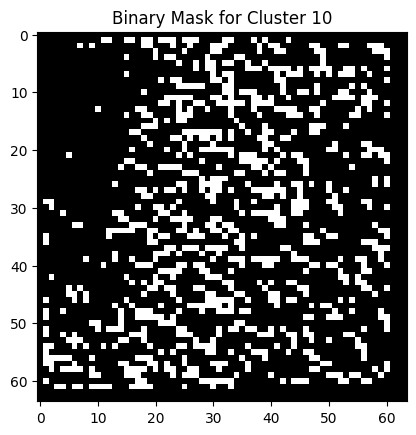

Cluster 10: Found 155 contours.


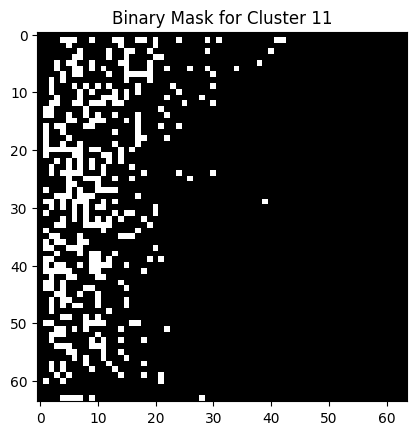

Cluster 11: Found 89 contours.


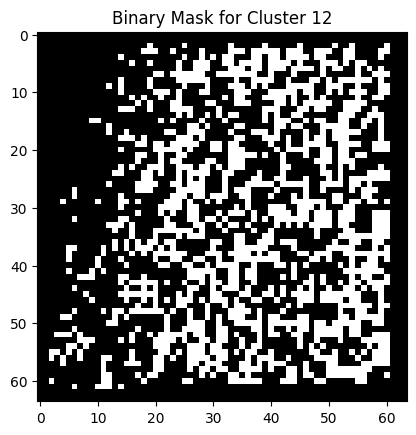

Cluster 12: Found 59 contours.


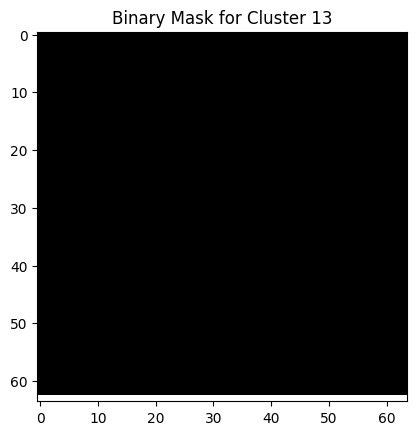

Cluster 13: Found 1 contours.


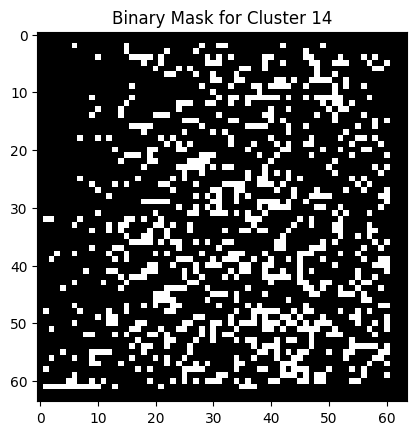

Cluster 14: Found 196 contours.


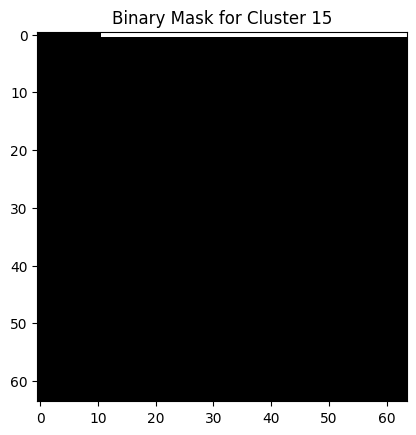

Cluster 15: Found 1 contours.


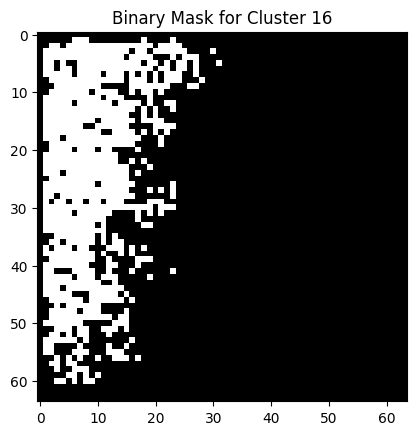

Cluster 16: Found 16 contours.


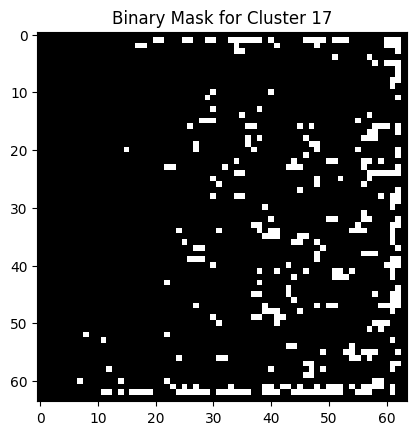

Cluster 17: Found 111 contours.


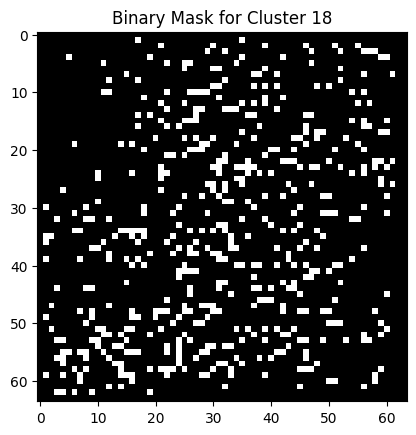

Cluster 18: Found 229 contours.


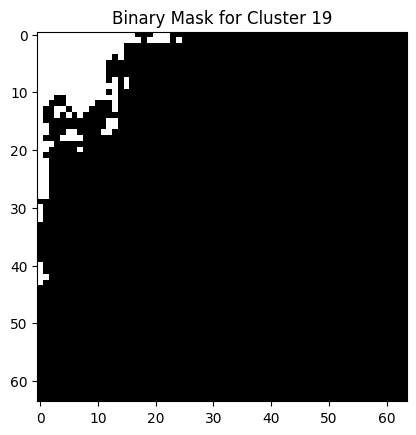

Cluster 19: Found 9 contours.


TypeError: Invalid shape (3, 3, 1024, 1024) for image data

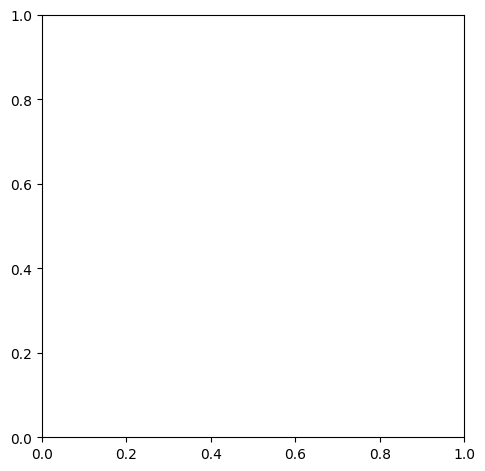

In [32]:
# Debug: Check cluster labels
print(f"Unique cluster labels: {np.unique(cluster_labels_grid)}")

image_np = sample_img[0].cpu().numpy().transpose(1, 2, 0)
visualized_img = image_np.copy()  # Create a copy for visualization

# Iterate over unique clusters
for cluster in np.unique(cluster_labels_grid):
    # Create a binary mask for the current cluster
    cluster_mask = (cluster_labels_grid == cluster).astype(np.uint8)
    
    if cluster_mask.ndim == 3:
        cluster_mask = np.sum(cluster_mask, axis=0)
    cluster_mask = (cluster_mask > 0).astype(np.uint8)
    
    # Debug: Visualize the binary mask
    plt.imshow(cluster_mask, cmap='gray')
    plt.title(f"Binary Mask for Cluster {cluster}")
    plt.show()

    # Find contours
    contours, _ = cv2.findContours(cluster_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Cluster {cluster}: Found {len(contours)} contours.")

    # Draw the contours on the visualization image
    cv2.drawContours(visualized_img, contours, -1, (255, 0, 0), 2)

# Visualize results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_img, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(visualized_img, cmap='gray')
plt.title("Particles Visualized")
plt.axis("off")

plt.tight_layout()
plt.show()

In [33]:
def visualize_single_cluster(sample_img, cluster_labels_grid, cluster_to_visualize, scale_factor=16):
    """
    Visualizes a single cluster on the image.

    Args:
        sample_img (torch.Tensor): The image tensor of shape [1, C, H, W].
        cluster_labels_grid (np.ndarray): The cluster labels grid of shape [B, H, W].
        cluster_to_visualize (int): The specific cluster to visualize.
        scale_factor (int): Scaling factor to map latent space coordinates to original image coordinates.
    
    Returns:
        None: Displays the image with the selected cluster highlighted.
    """
    print(f"Processing cluster: {cluster_to_visualize}")
    
    # Convert `sample_img` to NumPy for visualization
    image_np = sample_img[0].cpu().numpy().transpose(1, 2, 0)  # Convert CHW to HWC
    image_with_cluster = image_np.copy()
    
    # Extract all coordinates for the specified cluster
    coords = np.argwhere(cluster_labels_grid[0] == cluster_to_visualize)  # Get coordinates (row, col)
    print(f"Cluster {cluster_to_visualize}: {len(coords)} points found.")
    
    # Map the coordinates to the original image dimensions
    for coord in coords:
        y, x = coord * scale_factor  # Scale to original dimensions
        # Draw a small rectangle (just around the coordinate)
        cv2.rectangle(
            image_with_cluster,
            (x, y),
            (x + 1, y + 1),  # A box of size 1x1 pixel
            (255, 0, 0),  # Red color in BGR
            thickness=1  # Thickness of the rectangle
        )
    
    # Visualize the Image with Highlighted Cluster
    plt.figure(figsize=(12, 12))
    plt.imshow(image_with_cluster, cmap="gray")
    plt.title(f"Cluster {cluster_to_visualize} Highlighted")
    plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Processing cluster: 18
Cluster 18: 205 points found.


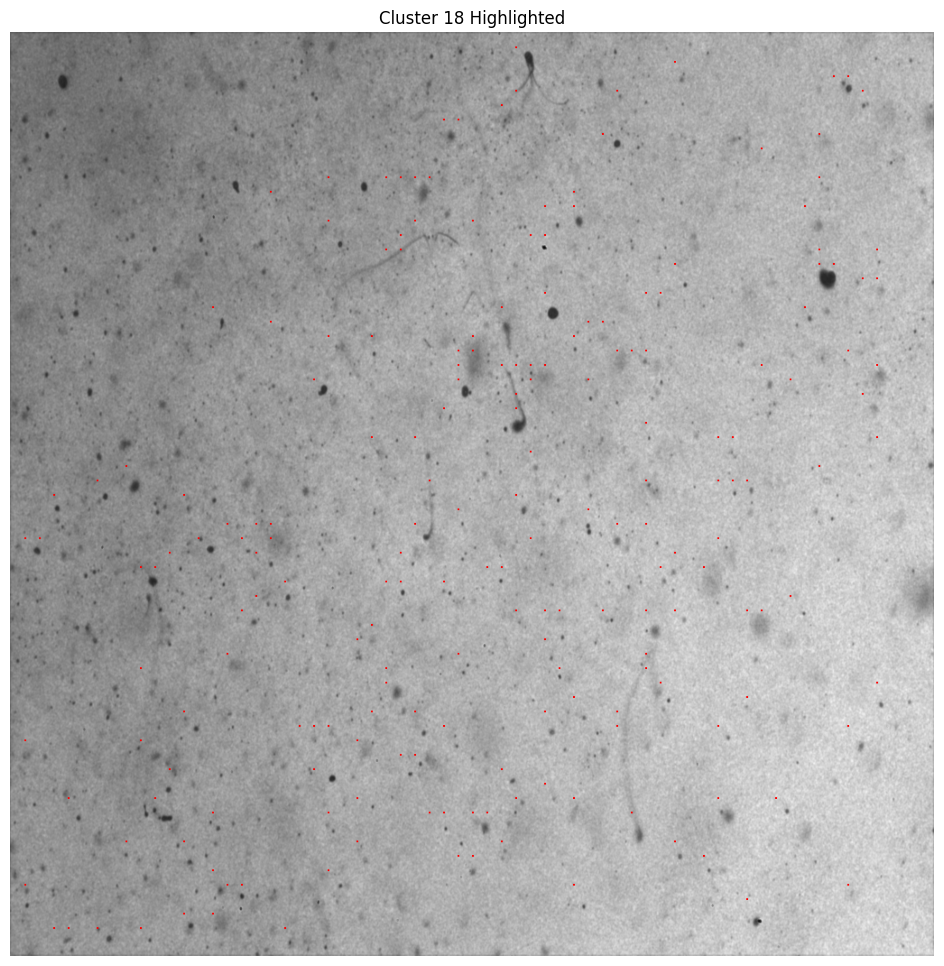

In [34]:
cluster_to_visualize = 18  # Specify the cluster you want to visualize
visualize_single_cluster(sample_img, cluster_labels_grid, cluster_to_visualize, scale_factor=16)